In [117]:
import pandas as pd
import numpy as np
import requests
import bs4 as bs

import datetime as dt
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0.1, 1))

### Scraping stats from espnCricinfo

In [3]:
def get_table(table_name, url=None):
    """
    Returns table if exists as csv. If url is mentioned, scrapes url page from espcricinfo for the table,
    saves as csv before returning.  
    """

    if url:
        if not os.path.exists(f"D:\\DataSets\\cric_competition\\{table_name}.csv"):
            resp = requests.get(url).text
            soup = bs.BeautifulSoup(resp, 'lxml')

            table = soup.find("table", {"class": "engineTable"})
            rows = table.find_all('tr')
            arr = []
            for tr in rows:
                arr.append(tr.text.strip('\n').replace('\n\n', '\n').replace('\n', '\t').split('\t'))

            df = pd.DataFrame(arr)
            df.to_csv(f"D:\\DataSets\\cric_competition\\{table_name}.csv", index=False)
        
    
    return pd.read_csv(f"D:\\DataSets\\cric_competition\\{table_name}.csv", header=1)

## Head to head results

In [187]:
match_results = get_table('match_results')

match_results['Match Date'] = pd.to_datetime(match_results['Match Date'])
match_results = match_results.set_index('Match Date').sort_index(ascending=False)

match_results['margin_by'] = match_results['Margin'].str.split(' ').str[1]
match_results['win_margin'] = match_results['Margin'].str.split(' ').str[0]
match_results.drop(['Margin', 'Scorecard'], axis=1, inplace=True)

match_results.rename(columns={'Team 1': 'home', 'Team 2': 'away', 'Winner': 'winner', 'Ground': 'ground'}, inplace=True)

match_results.head()

,home,away,winner,ground,margin_by,win_margin
Match Date,,,,,,
2019-01-18,Australia,India,India,Melbourne,wickets,7
2019-01-15,Australia,India,India,Adelaide,wickets,6
2019-01-12,Australia,India,Australia,Sydney,runs,34
2017-10-01,India,Australia,India,Nagpur,wickets,7
2017-09-28,India,Australia,Australia,Bengaluru,runs,21


### H2H results in India

Even with India's home advantage, Australia has beat india more number of times.

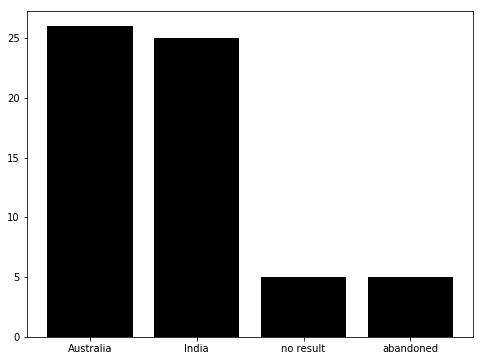

In [192]:
plt.figure(figsize=(8, 6))
a = pd.DataFrame(match_results[match_results['home'] == 'India']['winner'].value_counts())
plt.bar(a.index, a['winner'], color='k')
plt.show()

### Highest Totals against opposition

In [32]:
highest_totals = get_table('highest_totals')

highest_totals['Match Date'] = pd.to_datetime(highest_totals['Match Date'])
highest_totals['runs'] = highest_totals['Score'].str.split('/').str[0]
highest_totals['runs'] = highest_totals['runs'].astype('int')
highest_totals['for_wickets'] = highest_totals['Score'].str.split('/').str[1]
highest_totals['for_wickets'].fillna(0, inplace=True)
highest_totals['for_wickets'] = highest_totals['for_wickets'].astype('int')
highest_totals.drop('Scorecard', axis=1, inplace=True)
highest_totals.head()

,Team,Score,Overs,RR,Inns,Ground,Match Date,runs,for_wickets
0,India,383/6,50.0,7.66,1,Bengaluru,2013-11-02,383,6
1,India,362/1,43.3,8.32,2,Jaipur,2013-10-16,362,1
2,Australia,359/2,50.0,7.18,1,Johannesburg,2003-03-23,359,2
3,Australia,359/5,50.0,7.18,1,Sydney,2004-02-08,359,5
4,Australia,359/5,50.0,7.18,1,Jaipur,2013-10-16,359,5


#### Plot below shows highest total against opposition against achieved Run Rate. 

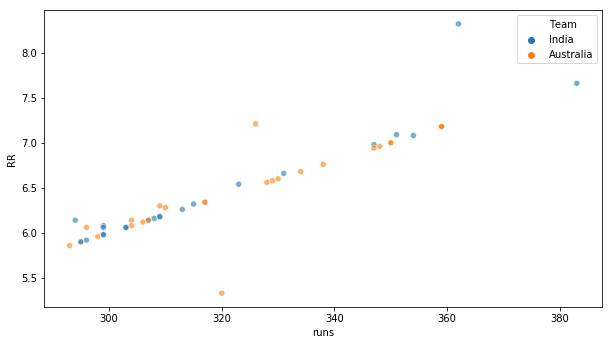

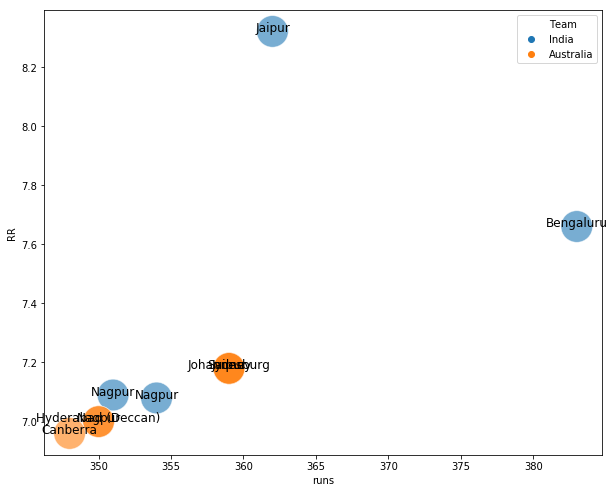

In [94]:
plt.figure(figsize=(10, 12))

plt.subplot(211)
sns.scatterplot(data=highest_totals, x='runs', y='RR', hue='Team', alpha=0.6)
plt.show()

plt.figure(figsize=(10, 18))
plt.subplot(212)
lim = highest_totals[:10]
ax = sns.scatterplot(data=lim, x='runs', y='RR', hue='Team', alpha=0.6, s=1000)

# xstart = math.floor(lim['runs'].min() - 10)
# xend = math.ceil(lim['runs'].max() + 10)
# ystart = lim['RR'].min() - 0.02
# yend = lim['RR'].max() + 0.02

# ax.set_xlim(xstart, xend)
# ax.set_ylim(ystart, yend)

#For each point, we add a text inside the bubble
for line in range(0, lim.shape[0]):
    ax.text(lim['runs'][line], lim['RR'][line], lim['Ground'][line],
            horizontalalignment='center', 
               size='small', color='black', fontsize=12)
plt.show()

### Highest aggregates (IND + AUS)

Records of combined runs of both innings of games played between India and Australia.

In [108]:
highest_aggregates = get_table('highest_aggregates')

highest_aggregates['Match Date'] = pd.to_datetime(highest_aggregates['Match Date'])
highest_aggregates['times_played'] = 1


data = highest_aggregates[['Runs', 'RR', 'Ground', 'times_played']].groupby('Ground').agg({'times_played': 'sum', 'Runs': 'median', 'RR': 'median'}).sort_values(['RR'], ascending=False).head(10)
data.head()

,times_played,Runs,RR
Ground,,,
Jaipur,1,721.0,7.71
Canberra,1,671.0,6.75
Johannesburg,1,593.0,6.63
Bengaluru,4,640.0,6.40
Perth,1,619.0,6.23


#### Grounds with the best median run-rate to the worst. (For all games between IND and AUS)

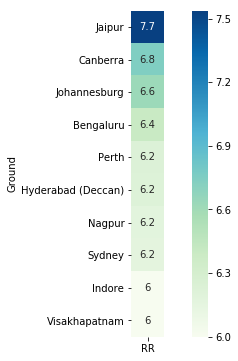

In [112]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['RR']], robust=True, cmap="GnBu", annot=True, square=True)
plt.show()

### Most Runs against opposition  (current squad)

In [116]:
most_runs = get_table('most_runs')

most_runs['year_start'] = most_runs['Span'].str.split('-').str[0] 
most_runs['year_start'] = most_runs['year_start'].astype('int')
most_runs['year_end'] = most_runs['Span'].str.split('-').str[1] 
most_runs['year_end'] = most_runs['year_end'].astype('int')

most_runs['current_squad'] = 0
most_runs.loc[most_runs['year_end'] == 2019, 'current_squad'] = 1

most_runs['team'] = most_runs['Player'].str.split('(').str[1].str.strip(')').str.lower()

most_runs.drop('Span', axis=1, inplace=True)

most_runs_curr = most_runs[most_runs['current_squad'] == 1]
most_runs_curr

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s,year_start,year_end,current_squad,team
2,RG Sharma (INDIA),31,31,4,1778,209,65.85,1828,97.26,7,5,1,141,66,2007,2019,1,india
4,MS Dhoni (INDIA),51,44,10,1548,139*,45.52,1923,80.49,2,10,2,101,30,2006,2019,1,india
6,V Kohli (INDIA),31,29,3,1335,118,51.34,1430,93.35,6,5,2,118,15,2009,2019,1,india
18,AJ Finch (AUS),20,19,0,856,124,45.05,1001,85.51,2,6,0,88,18,2013,2019,1,aus
28,S Dhawan (INDIA),18,18,1,681,126,40.05,699,97.42,2,4,2,83,6,2010,2019,1,india
34,GJ Maxwell (AUS),19,18,2,603,96,37.68,444,135.81,0,4,0,53,29,2013,2019,1,aus
39,SE Marsh (AUS),11,11,0,508,131,46.18,599,84.80,2,3,1,39,6,2009,2019,1,aus


#### Plot of SR vs AVG of a player. Size of bubble indicates number of innings played against opposition.

C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


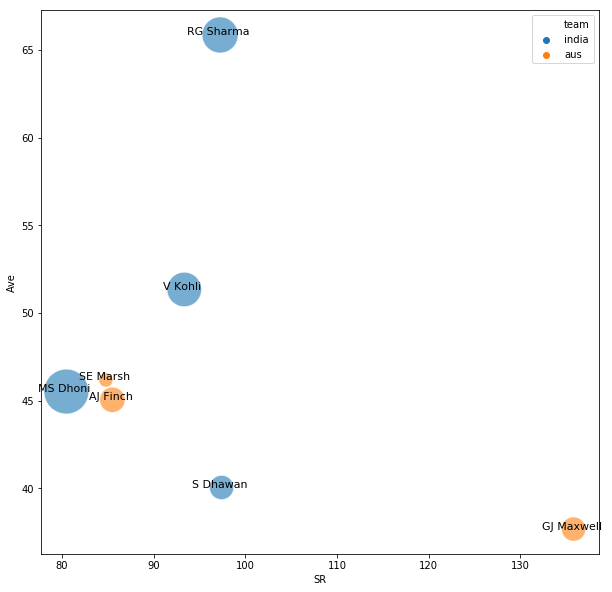

In [124]:
plt.figure(figsize=(10, 10))
s = scaler.fit_transform(most_runs_curr.Inns.values.reshape(-1, 1))

ax = sns.scatterplot(data=most_runs_curr, x='SR', y='Ave', hue='team', s=s*2000, alpha=0.6)

for line in most_runs_curr.index.values:
    ax.text(most_runs_curr['SR'][line], most_runs_curr['Ave'][line], most_runs_curr['Player'][line].split('(')[0],
            horizontalalignment='center', 
                       size='small', color='black', fontsize=11)
    
plt.show()

### most 6s in a single match against opposition

In [126]:
most_6s_total = get_table('most_6s_total')

most_6s_total['Match Date'] = pd.to_datetime(most_6s_total['Match Date'])
most_6s_total['Runs'] = most_6s_total['Runs'].str.replace('*', '').astype('int')

most_6s_total.drop('Scorecard', axis=1, inplace=True)
recent = most_6s_total[most_6s_total['Match Date'].dt.year > 2012]
recent.head()

,Player,Runs,Balls,4s,6s,SR,Team,Ground,Match Date
0,RG Sharma,209,158,12,16,132.27,India,Bengaluru,2013-11-02
4,V Kohli,100,52,8,7,192.30,India,Jaipur,2013-10-16
5,GJ Maxwell,60,22,3,7,272.72,Australia,Bengaluru,2013-11-02
6,RG Sharma,171,163,13,7,104.90,India,Perth,2016-01-12
8,JP Faulkner,64,29,2,6,220.68,Australia,Mohali,2013-10-19


#### Plot of runs made vs 6s hit. Size indicates strike-rate.

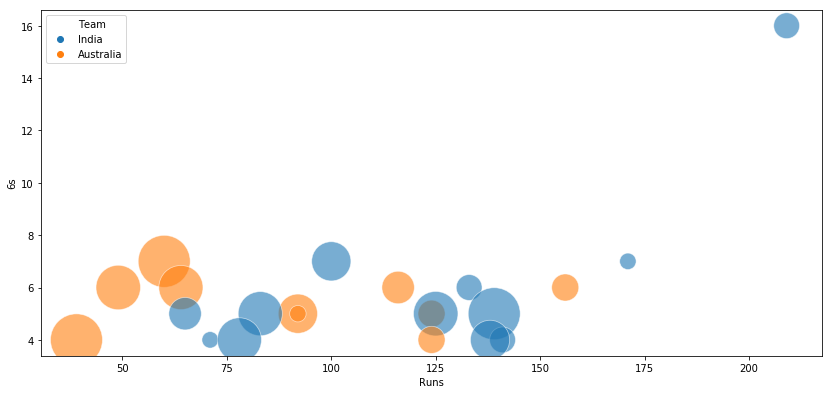

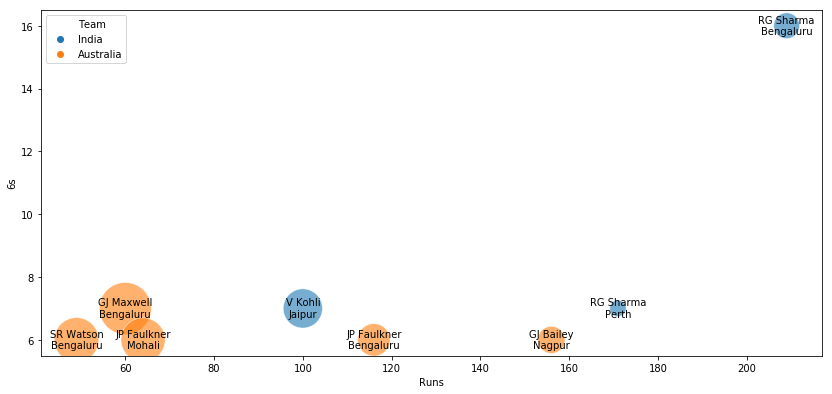

In [151]:
plt.figure(figsize=(14, 14))
plt.subplot(211)
sns.scatterplot(data=recent, x='Runs', y='6s', hue='Team', s=s*2700, alpha=0.6)
plt.show()

plt.figure(figsize=(14, 14))
plt.subplot(212)
data = recent.head(8)
s = scaler.fit_transform(data['SR'].values.reshape(-1, 1))

ax = sns.scatterplot(data=data, x='Runs', y='6s', hue='Team', s=s*2700, alpha=0.6)

for line in data.index.values:
    ax.text(data['Runs'][line], data['6s'][line], data['Player'][line] + '\n' + data['Ground'][line],
            horizontalalignment='center', verticalalignment='center', 
                       size='small', color='black', fontsize=10)
plt.show()

### Most runs from 4s + 6s against oppostion

In [153]:
most_4s_6s = get_table('most_4s_6s_inning')
most_4s_6s['Match Date'] = pd.to_datetime(most_4s_6s['Match Date'])
most_4s_6s['Runs'] = most_4s_6s['Runs'].str.replace('*', '').astype('int')
recent = most_4s_6s[most_4s_6s['Match Date'].dt.year > 2012]
recent.head()

,Player,Runs,Balls,4s,6s,4+6,SR,Team,Ground,Match Date,Scorecard
0,RG Sharma,209,158,12,16,144,132.27,India,Bengaluru,2013-11-02,ODI # 3428
2,RG Sharma,171,163,13,7,94,104.90,India,Perth,2016-01-12,ODI # 3723
3,RG Sharma,141,123,17,4,92,114.63,India,Jaipur,2013-10-16,ODI # 3420
4,GJ Bailey,156,114,13,6,88,136.84,Australia,Nagpur,2013-10-30,ODI # 3424
5,JP Faulkner,116,73,11,6,80,158.90,Australia,Bengaluru,2013-11-02,ODI # 3428


#### Plot of balls-faced vs runs-made. Size indicated runs made from 4s+6s

C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


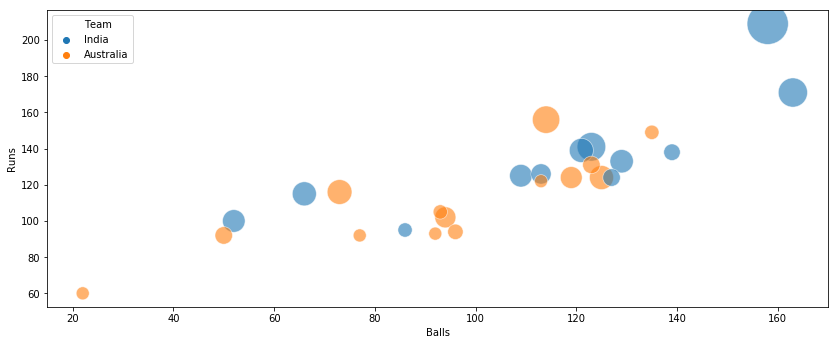

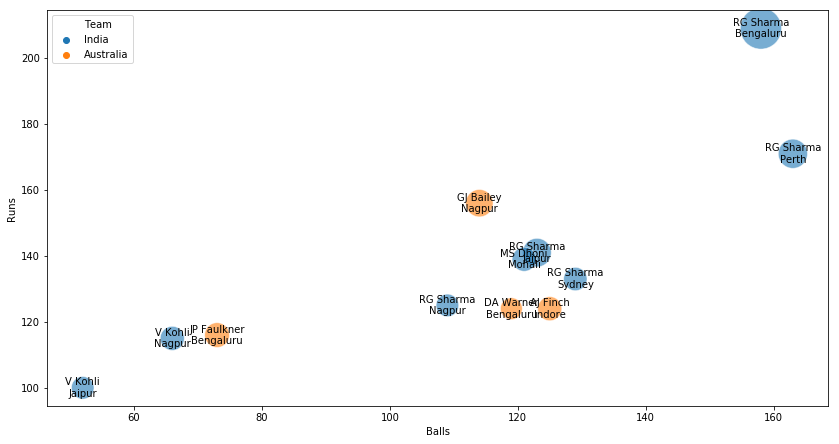

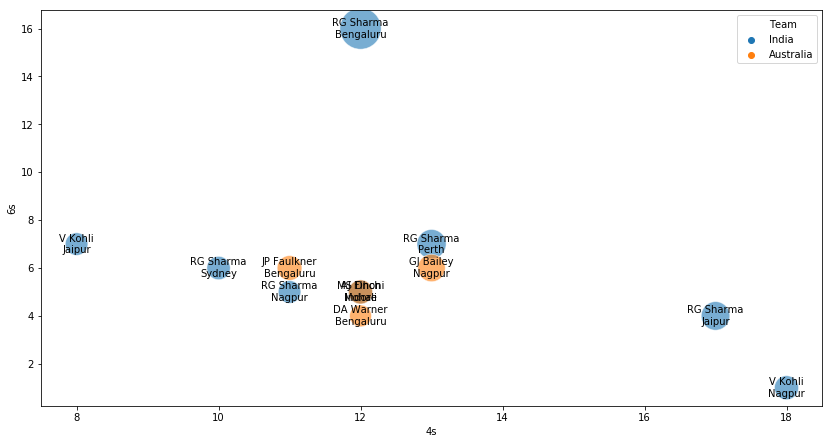

In [212]:
s = scaler.fit_transform(recent['4+6'].values.reshape(-1, 1))

plt.figure(figsize=(14, 12))
plt.subplot(211)
sns.scatterplot(data=recent, x='Balls', y='Runs', hue='Team', s=s*1700, alpha=0.6)
plt.show()


plt.figure(figsize=(14, 16))
plt.subplot(212)
data = recent.head(12)
ax = sns.scatterplot(data=data, x='Balls', y='Runs', hue='Team', s=s*1700, alpha=0.6)

for line in data.index.values:
    ax.text(data['Balls'][line], data['Runs'][line], data['Player'][line] + '\n' + data['Ground'][line],
            horizontalalignment='center', verticalalignment='center', 
                       size='small', color='black', fontsize=10)
plt.show()


plt.figure(figsize=(14, 16))
plt.subplot(212)
data = recent.head(12)
ax = sns.scatterplot(data=data, x='4s', y='6s', hue='Team', s=s*1700, alpha=0.6)

for line in data.index.values:
    ax.text(data['4s'][line], data['6s'][line], data['Player'][line] + '\n' + data['Ground'][line],
            horizontalalignment='center', verticalalignment='center', 
                       size='small', color='black', fontsize=10)
plt.show()

### Most career wickets against opposition 

In [26]:
most_wickets = get_table('most_wickets_total')

most_wickets['year_start'] = most_wickets['Span'].str.split('-').str[0] 
most_wickets['year_start'] = most_wickets['year_start'].astype('int')
most_wickets['year_end'] = most_wickets['Span'].str.split('-').str[1] 
most_wickets['year_end'] = most_wickets['year_end'].astype('int')

most_wickets['current_squad'] = 0
most_wickets.loc[most_wickets['year_end'] == 2019, 'current_squad'] = 1

most_wickets['team'] = most_wickets['Player'].str.split('(').str[1].str.strip(')').str.lower()

most_wickets.drop('Span', axis=1, inplace=True)

most_wickets_curr = most_wickets[most_wickets['current_squad'] == 1]
most_wickets_curr

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,BBI,Ave,Econ,SR,4,5,year_start,year_end,current_squad,team
26,RA Jadeja (INDIA),26,24,216.1,3,1162,20,3/35,58.10,5.37,64.8,0,0,2009,2019,1,india
32,B Kumar (INDIA),15,15,126.0,7,654,16,4/45,40.87,5.19,47.2,1,0,2013,2019,1,india
42,Mohammed Shami (INDIA),10,9,82.0,3,485,13,3/42,37.30,5.91,37.8,0,0,2013,2019,1,india


### Best bowling figures in an inning against opposition

In [29]:
bowling_fig = get_table('best_bowling_fig_inning')


bowling_fig['Match Date'] = pd.to_datetime(bowling_fig['Match Date'])
bowling_fig.drop('Scorecard', axis=1, inplace=True)

current = bowling_fig[bowling_fig['Match Date'].dt.year > 2013]
current

,Player,Overs,Mdns,Runs,Wkts,Econ,Team,Ground,Match Date
3,YS Chahal,10.0,0,42,6,4.2,India,Melbourne,2019-01-18
4,MA Starc,10.0,2,43,6,4.3,Australia,Melbourne,2015-01-18
19,KW Richardson,10.0,1,68,5,6.8,Australia,Canberra,2016-01-20


### Most runs conceded in an inning against oppostion

In [173]:
conceded = get_table('most_conceded_inning')

conceded['Match Date'] = pd.to_datetime(conceded['Match Date'])
conceded.drop('Scorecard', axis=1, inplace=True)

current = conceded[conceded['Match Date'].dt.year > 2013]
current

,Player,Overs,Mdns,Runs,Wkts,Econ,Team,Ground,Match Date
5,UT Yadav,8.0,0,82,1,10.25,India,Sydney,2016-01-23
12,I Sharma,10.0,0,77,4,7.70,India,Canberra,2016-01-20
13,MR Marsh,9.4,0,77,1,7.96,Australia,Sydney,2016-01-23
14,NM Lyon,10.0,0,76,1,7.60,Australia,Canberra,2016-01-20
15,Mohammed Siraj,10.0,0,76,0,7.60,India,Adelaide,2019-01-15
22,MM Sharma,10.0,0,75,2,7.50,India,Sydney,2015-03-26
23,Kuldeep Yadav,10.0,0,75,2,7.50,India,Indore,2017-09-24
27,SM Boland,10.0,0,74,0,7.40,Australia,Perth,2016-01-12
28,UT Yadav,10.0,0,74,1,7.40,India,Brisbane,2016-01-15
29,R Dhawan,10.0,0,74,1,7.40,India,Sydney,2016-01-23


#### Plot of economy vs wickets taken. Size indicated runs conceded.

C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


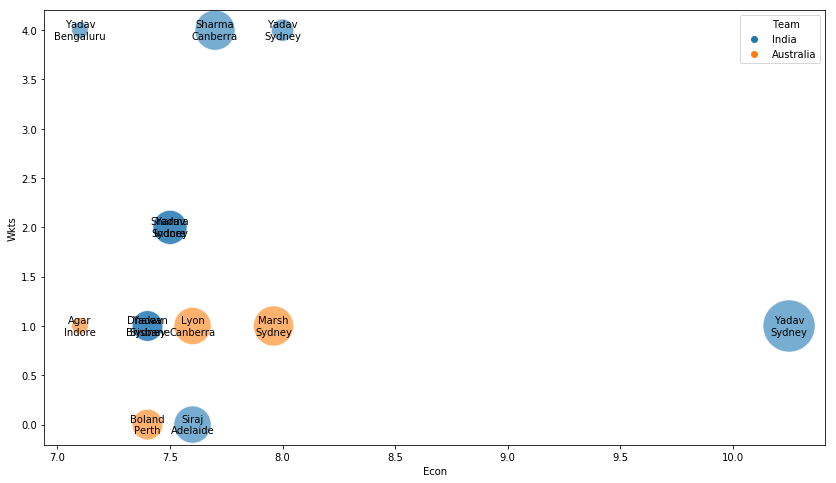

In [183]:
s = scaler.fit_transform(current.Runs.values.reshape(-1, 1))

plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=current, x='Econ', y='Wkts', hue='Team', s=s*2700, alpha=0.6)

for line in current.index.values:
    ax.text(current['Econ'][line], current['Wkts'][line], current['Player'][line].split(' ')[1] + '\n' + current['Ground'][line],
            horizontalalignment='center', verticalalignment='center', 
                       size='small', color='black', fontsize=10)

plt.show()

## Form - India

In [194]:
form1 = get_table('form_ind_2018')
form2 = get_table('form_ind_2019')
form = form1.append(form2)

form = form.dropna().reset_index().drop(['index', 'Scorecard'], axis=1)
form['Match Date'] = pd.to_datetime(form['Match Date'])
form['result'] = 0
form.loc[form['Winner'] == 'India', 'result'] = 1

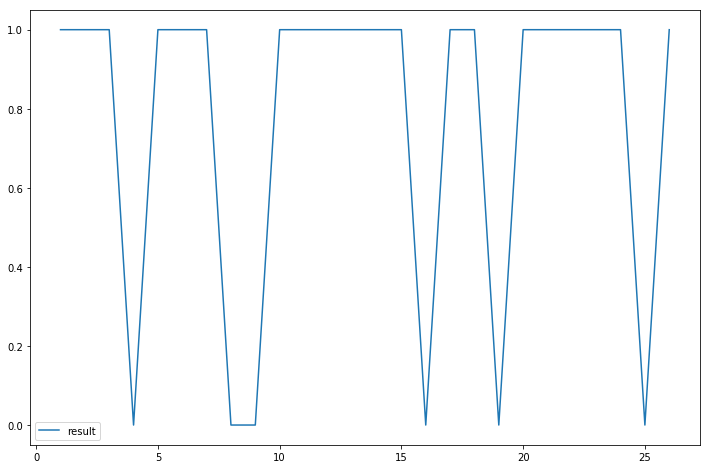

Wins: 20
Loss: 6
%win: 76.92


In [204]:
form.plot(x=(np.array(form.index))+1, y='result', figsize=(12, 8))
plt.show()

win = len(form[form.result == 1])
loss = len(form[form.result == 0])
print(f"Wins: {win}\nLoss: {loss}\n%win: {round(win/(win + loss) * 100, 2)}")

## Form - Aus

In [206]:
form1 = get_table('form_aus_2018')
form2 = get_table('form_aus_2019')
form = form1.append(form2)

form = form.dropna().reset_index().drop(['index', 'Scorecard'], axis=1)
form['Match Date'] = pd.to_datetime(form['Match Date'])
form['result'] = 0
form.loc[form['Winner'] == 'Australia', 'result'] = 1
form.head()

,Team 1,Team 2,Winner,Margin,Ground,Match Date,result
0,Australia,England,England,5 wickets,Melbourne,2018-01-14,0
1,Australia,England,England,4 wickets,Brisbane,2018-01-19,0
2,Australia,England,England,16 runs,Sydney,2018-01-21,0
3,Australia,England,Australia,3 wickets,Adelaide,2018-01-26,1
4,Australia,England,England,12 runs,Perth,2018-01-28,0


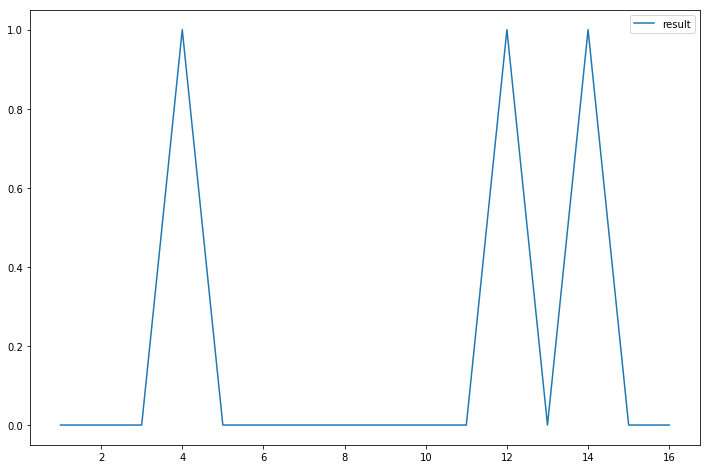

Wins: 3
Loss: 13
%win: 18.75


In [207]:
form.plot(x=(np.array(form.index))+1, y='result', figsize=(12, 8))
plt.show()

win = len(form[form.result == 1])
loss = len(form[form.result == 0])
print(f"Wins: {win}\nLoss: {loss}\n%win: {round(win/(win + loss) * 100, 2)}")

## Stadium Stats

In [29]:
hyd_agg = get_table("hyd_agg", "http://stats.espncricinfo.com/ci/engine/records/team/highest_match_aggregates.html?class=2;id=1981;type=ground")
hyd_agg['ground'] = 'hydrabad'

nagpur_agg = get_table("nagpur_agg", "http://stats.espncricinfo.com/ci/engine/records/team/highest_match_aggregates.html?class=2;id=367;type=ground")
nagpur_agg['ground'] = 'nagpur'

ranchi_agg = get_table("ranchi_agg", "http://stats.espncricinfo.com/ci/engine/records/team/highest_match_aggregates.html?class=2;id=2575;type=ground")
ranchi_agg['ground'] = 'ranchi'

mohali_agg = get_table("mohali_agg", "http://stats.espncricinfo.com/ci/engine/records/team/highest_match_aggregates.html?class=2;id=1015;type=ground")
mohali_agg['ground'] = 'mohali'

delhi_agg = get_table("delhi_agg", "http://stats.espncricinfo.com/ci/engine/records/team/highest_match_aggregates.html?class=2;id=333;type=ground")
delhi_agg['ground'] = 'delhi'

stadium_runs_agg = hyd_agg.append([nagpur_agg, ranchi_agg, mohali_agg, delhi_agg]).reset_index(drop=True)
stadium_runs_agg.drop(index=70, inplace=True)

In [30]:
stadium_runs_agg.groupby('ground').agg({'Runs': 'mean', 'Wkts': 'median', 'RR': 'median'}).sort_values('RR', ascending=False)

,Runs,Wkts,RR
ground,,,
nagpur,509.357143,14.0,6.005
hydrabad,538.400000,14.0,5.450
ranchi,427.250000,14.0,5.440
mohali,496.250000,15.5,5.255
delhi,451.173913,15.0,4.920


# Predictions

### Latest Squads for upcoming ODI (For reference)

__INDIA__

__1st and 2nd ODI Squad:__ Rohit Sharma, Shikhar Dhawan, Virat Kohli(c), Ambati Rayudu, Lokesh Rahul, Rishabh Pant, MS Dhoni, Kedar Jadhav, Vijay Shankar, Kuldeep Yadav, Siddarth Kaul, Mohammed Shami, Jasprit Bumrah, Yuzvendra Chahal, Ravindra Jadeja

__3rd, 4th & 5th ODI Squad:__ Rohit Sharma, Shikhar Dhawan, Virat Kohli(c), Ambati Rayudu, Lokesh Rahul, Rishabh Pant, MS Dhoni, Kedar Jadhav, Vijay Shankar, Bhuvneshwar Kumar, Kuldeep Yadav, Mohammed Shami, Jasprit Bumrah, Yuzvendra Chahal, Ravindra Jadeja

__AUSTRALIA__

Aaron Finch (C), Usman Khawaja, Shaun Marsh, Peter Handscomb, Glenn Maxwell, Ashton Turner, Marcus Stoinis, Alex Carey (W), Pat Cummins, Nathan Coulter-Nile, Jhye Richardson, Andrew Tye, Jason Behrendorff, Nathan Lyon, Adam Zampa, D'Arcy Short

# Winner of the Series

### Pick: INDIA

India currently has a much better form in ODIs. They also have the home advantage. In India the pitches are more flat generally so it’s easier to bat. Also, India has won most of their games when Kedar Jadhav was in the team.

India's win percent in all ODIs for the last two years is around 77% while Australia's is only 18.75%

# Series Output

### Pick: INDIA  3 - 2 AUSTRALIA

Although India have the home advantage, they will find it difficult to whitewash the series. These are the last 5 ODI matches for the Indian team before they head into the World Cup and are still trying to find the perfect team combination and may not play their best XI for every match to give the bench some game time. Therefore it is possible they may lose a couple of games. 

Australia have good pace bowlers compared to India. Besides generally being a good pitch for bowlers, Mohali is also good for pace.


# Highest run scorer 

### Pick: Rohit Sharma

By analyzing "most carreer runs against opposition", "most 6s in a single match against opposition", "Most runs from 4s + 6s against oppostion" only one player stands out and that is Rohit Sharma. 

# Highest wicket-taker

### Pick: Y Chahal

Indian conditions tend to favour spin bowlers. Historically Australian batsmen have not been good players of spin. India's leg-spinning duo, Kuldeep Yadav and Yuzvendra Chahal have built a very succesful partnership and they regularly take wickets in the middle overs.

pace bowler Kane richardson is out, which will make life tougher for Australia and thus will not be able to take full advantage of pitch at Mohali.

# Player with Maximum sixes

### Pick: Rohit Sharma

The player with the most sixes would be a toss-up between Rohit Sharma and Glen Maxwell. They both can hit the ball a long way but Rohit Sharma may emerge as the victor in this clash as Glen Maxwell plays as a floater in the Australian middle order (Therefore is less likely to face a large amount of balls). There is a direct correlation between number of 6's and balls faced. It's become common to see him bat at the no. 7 position which means he will get lesser time in the middle than Rohit Sharma and lesser opportunities to hit a sixer.

# Player with Maximum fours

### Pick: Rohit Sharma

Analyzing "most 6s in a single match against opposition", "Most runs from 4s + 6s against oppostion" we can safely say that player with the maximum sixes (and starts early in the game) is more likely to also be the player with maximum 4s. Although Virat Kohli is also in contention for this spot as we can see by the "4s vs 6s" plot. 